In [ ]:
# prompt: add dependencies

!pip install -q <library_name> # replace <library_name> with the name of the library you want to install


In [ ]:
!pip install torch --upgrade --force-reinstall
!pip install scikit-learn
!pip install pykan

  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl (779.1 MB)
  Using cached filelock-3.15.4-py3-none-any.whl (16 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Using cached sympy-1.13.0-py3-none-any.whl (6.2 MB)
  Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
  Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
  Using cached fsspec-2024.6.1-py3-none-any.whl (177 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Assuming 'kan.py' is a module with KAN class properly defined
from kan import KAN  # Importing traditional KAN if needed

# Load dataset
df = pd.read_csv("/content/heart_cleveland_upload.csv")

# Preprocessing
X = df[df.columns[:-1]]
y = df['condition']
X = StandardScaler().fit_transform(X)  # Normalizing data

# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to Torch tensors

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.to_numpy(), dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Initialize MLP
mlp = MLPClassifier(random_state=42, max_iter=1000)
start_time = time.time()
mlp.fit(X_train, y_train)
mlp_duration = time.time() - start_time
mlp_preds = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, mlp_preds)
mlp_f1 = f1_score(y_test, mlp_preds)
mlp_auc = roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])

# Define and initialize the KAN models
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, wavelet_type='dog'):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.wavelet_type = wavelet_type
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        x = torch.mm(x, self.weights.t()) + self.bias
        return F.relu(x)  # Assuming ReLU activation; adjust as necessary

class KANWavelet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, wavelet_type='dog'):
        super(KANWavelet, self).__init__()
        layers = [KANLinear(input_size, hidden_sizes[0], wavelet_type)]
        for i in range(1, len(hidden_sizes)):
            layers.append(KANLinear(hidden_sizes[i-1], hidden_sizes[i], wavelet_type))
        layers.append(KANLinear(hidden_sizes[-1], output_size, wavelet_type))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Initialize traditional KAN and Wavelet KAN
kan = KAN(width=[X_train.shape[1],10,10,2], grid=3, k=3)
kan_model = KANWavelet(input_size=X_train.shape[1], hidden_sizes=[10, 10], output_size=2, wavelet_type='dog')
optimizer_kan = optim.Adam(kan.parameters(), lr=0.01)
optimizer_wavkan = optim.Adam(kan_model.parameters(), lr=0.01)

# Define training and evaluation function
def train_and_evaluate(model, optimizer, X_train, y_train, X_test, y_test, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = F.cross_entropy(outputs, y_train)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X_test), dim=1)
        acc = accuracy_score(y_test, preds.numpy())
        f1 = f1_score(y_test, preds.numpy())
        auc = roc_auc_score(y_test, F.softmax(model(X_test), dim=1)[:, 1].numpy())
    return acc, f1, auc

# Train and evaluate traditional KAN and Wavelet KAN
kan_start_time = time.time()
kan_acc, kan_f1, kan_auc = train_and_evaluate(kan, optimizer_kan, X_train_torch, y_train_torch, X_test_torch, y_test_torch)
kan_duration = time.time() - kan_start_time

wkan_start_time = time.time()
wavkan_acc, wavkan_f1, wavkan_auc = train_and_evaluate(kan_model, optimizer_wavkan, X_train_torch, y_train_torch, X_test_torch, y_test_torch)
wkan_duration = time.time() - wkan_start_time

# Print results
print(f"MLP - Accuracy: {mlp_acc:.2f}, F1 Score: {mlp_f1:.2f}, AUC: {mlp_auc:.2f}, Time: {mlp_duration:.2f}s")
print(f"KAN - Accuracy: {kan_acc:.2f}, F1 Score: {kan_f1:.2f}, AUC: {kan_auc:.2f}, Time: {kan_duration:.2f}s")
print(f"WavKAN - Accuracy: {wavkan_acc:.2f}, F1 Score: {wavkan_f1:.2f}, AUC: {wavkan_auc:.2f}, Time: {wkan_duration:.2f}s")


MLP - Accuracy: 0.73, F1 Score: 0.74, AUC: 0.82, Time: 2.83s
KAN - Accuracy: 0.78, F1 Score: 0.79, AUC: 0.84, Time: 15.20s
WavKAN - Accuracy: 0.78, F1 Score: 0.76, AUC: 0.79, Time: 0.14s


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Assuming 'kan.py' is a module with KAN class properly defined
from kan import KAN  # Importing traditional KAN if needed

# Load dataset
df = pd.read_csv("/content/heart_cleveland_upload.csv")

# Preprocessing
X = df[df.columns[:-1]]
y = df['condition']
X = StandardScaler().fit_transform(X)  # Normalizing data

# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to Torch tensors

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.to_numpy(), dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Initialize MLP
mlp = MLPClassifier(random_state=42, max_iter=1000)
start_time = time.time()
mlp.fit(X_train, y_train)
mlp_duration = time.time() - start_time
mlp_preds = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, mlp_preds)
mlp_f1 = f1_score(y_test, mlp_preds)
mlp_auc = roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])

# Define and initialize the KAN models
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, wavelet_type='dog'):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.wavelet_type = wavelet_type
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        x = torch.mm(x, self.weights.t()) + self.bias
        return F.relu(x)  # Assuming ReLU activation; adjust as necessary

class KANWavelet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, wavelet_type='dog'):
        super(KANWavelet, self).__init__()
        layers = [KANLinear(input_size, hidden_sizes[0], wavelet_type)]
        for i in range(1, len(hidden_sizes)):
            layers.append(KANLinear(hidden_sizes[i-1], hidden_sizes[i], wavelet_type))
        layers.append(KANLinear(hidden_sizes[-1], output_size, wavelet_type))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Initialize traditional KAN and Wavelet KAN
kan = KAN(width=[X_train.shape[1],2], grid=10, k=10)
kan_model = KANWavelet(input_size=X_train.shape[1], hidden_sizes=[10], output_size=2, wavelet_type='dog')
optimizer_kan = optim.Adam(kan.parameters(), lr=0.01)
optimizer_wavkan = optim.Adam(kan_model.parameters(), lr=0.01)

# Define training and evaluation function
def train_and_evaluate(model, optimizer, X_train, y_train, X_test, y_test, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = F.cross_entropy(outputs, y_train)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X_test), dim=1)
        acc = accuracy_score(y_test, preds.numpy())
        f1 = f1_score(y_test, preds.numpy())
        auc = roc_auc_score(y_test, F.softmax(model(X_test), dim=1)[:, 1].numpy())
    return acc, f1, auc

# Train and evaluate traditional KAN and Wavelet KAN
kan_start_time = time.time()
kan_acc, kan_f1, kan_auc = train_and_evaluate(kan, optimizer_kan, X_train_torch, y_train_torch, X_test_torch, y_test_torch)
kan_duration = time.time() - kan_start_time

wkan_start_time = time.time()
wavkan_acc, wavkan_f1, wavkan_auc = train_and_evaluate(kan_model, optimizer_wavkan, X_train_torch, y_train_torch, X_test_torch, y_test_torch)
wkan_duration = time.time() - wkan_start_time

# Print results
print(f"MLP - Accuracy: {mlp_acc:.2f}, F1 Score: {mlp_f1:.2f}, AUC: {mlp_auc:.2f}, Time: {mlp_duration:.2f}s")
print(f"KAN - Accuracy: {kan_acc:.2f}, F1 Score: {kan_f1:.2f}, AUC: {kan_auc:.2f}, Time: {kan_duration:.2f}s")
print(f"WavKAN - Accuracy: {wavkan_acc:.2f}, F1 Score: {wavkan_f1:.2f}, AUC: {wavkan_auc:.2f}, Time: {wkan_duration:.2f}s")


MLP - Accuracy: 0.73, F1 Score: 0.74, AUC: 0.82, Time: 1.25s
KAN - Accuracy: 0.82, F1 Score: 0.81, AUC: 0.86, Time: 2.05s
WavKAN - Accuracy: 0.53, F1 Score: 0.00, AUC: 0.73, Time: 0.11s


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Assuming 'kan.py' is a module with KAN class properly defined
from kan import KAN  # Importing traditional KAN if needed

# Load dataset
df = pd.read_csv("/content/heart_cleveland_upload.csv")

# Preprocessing
X = df[df.columns[:-1]]
y = df['condition']
X = StandardScaler().fit_transform(X)  # Normalizing data

# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to Torch tensors

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.to_numpy(), dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Initialize MLP
mlp = MLPClassifier(random_state=42, max_iter=1000)
start_time = time.time()
mlp.fit(X_train, y_train)
mlp_duration = time.time() - start_time
mlp_preds = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, mlp_preds)
mlp_f1 = f1_score(y_test, mlp_preds)
mlp_auc = roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])

# Define and initialize the KAN models
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, wavelet_type='dog'):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.wavelet_type = wavelet_type
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        x = torch.mm(x, self.weights.t()) + self.bias
        return F.relu(x)  # Assuming ReLU activation; adjust as necessary

class KANWavelet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, wavelet_type='dog'):
        super(KANWavelet, self).__init__()
        layers = [KANLinear(input_size, hidden_sizes[0], wavelet_type)]
        for i in range(1, len(hidden_sizes)):
            layers.append(KANLinear(hidden_sizes[i-1], hidden_sizes[i], wavelet_type))
        layers.append(KANLinear(hidden_sizes[-1], output_size, wavelet_type))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Initialize traditional KAN and Wavelet KAN
kan = KAN(width=[X_train.shape[1],2], grid=15, k=15)
kan_model = KANWavelet(input_size=X_train.shape[1], hidden_sizes=[10,10], output_size=2, wavelet_type='dog')
optimizer_kan = optim.Adam(kan.parameters(), lr=0.01)
optimizer_wavkan = optim.Adam(kan_model.parameters(), lr=0.01)

# Define training and evaluation function
def train_and_evaluate(model, optimizer, X_train, y_train, X_test, y_test, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = F.cross_entropy(outputs, y_train)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X_test), dim=1)
        acc = accuracy_score(y_test, preds.numpy())
        f1 = f1_score(y_test, preds.numpy())
        auc = roc_auc_score(y_test, F.softmax(model(X_test), dim=1)[:, 1].numpy())
    return acc, f1, auc

# Train and evaluate traditional KAN and Wavelet KAN
kan_start_time = time.time()
kan_acc, kan_f1, kan_auc = train_and_evaluate(kan, optimizer_kan, X_train_torch, y_train_torch, X_test_torch, y_test_torch)
kan_duration = time.time() - kan_start_time

wkan_start_time = time.time()
wavkan_acc, wavkan_f1, wavkan_auc = train_and_evaluate(kan_model, optimizer_wavkan, X_train_torch, y_train_torch, X_test_torch, y_test_torch)
wkan_duration = time.time() - wkan_start_time

# Print results
print(f"MLP - Accuracy: {mlp_acc:.2f}, F1 Score: {mlp_f1:.2f}, AUC: {mlp_auc:.2f}, Time: {mlp_duration:.2f}s")
print(f"KAN - Accuracy: {kan_acc:.2f}, F1 Score: {kan_f1:.2f}, AUC: {kan_auc:.2f}, Time: {kan_duration:.2f}s")
print(f"WavKAN - Accuracy: {wavkan_acc:.2f}, F1 Score: {wavkan_f1:.2f}, AUC: {wavkan_auc:.2f}, Time: {wkan_duration:.2f}s")


MLP - Accuracy: 0.73, F1 Score: 0.74, AUC: 0.82, Time: 3.31s
KAN - Accuracy: 0.82, F1 Score: 0.81, AUC: 0.86, Time: 4.59s
WavKAN - Accuracy: 0.78, F1 Score: 0.77, AUC: 0.79, Time: 0.17s


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Assuming 'kan.py' is a module with KAN class properly defined
from kan import KAN  # Importing traditional KAN if needed

# Load dataset
df = pd.read_csv("/content/heart_cleveland_upload.csv")

# Preprocessing
X = df[df.columns[:-1]]
y = df['condition']
X = StandardScaler().fit_transform(X)  # Normalizing data

# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to Torch tensors

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.to_numpy(), dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Initialize MLP
mlp = MLPClassifier(random_state=42, max_iter=1000)
start_time = time.time()
mlp.fit(X_train, y_train)
mlp_duration = time.time() - start_time
mlp_preds = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, mlp_preds)
mlp_f1 = f1_score(y_test, mlp_preds)
mlp_auc = roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])

# Define and initialize the KAN models
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, wavelet_type='dog'):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.wavelet_type = wavelet_type
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        x = torch.mm(x, self.weights.t()) + self.bias
        return F.relu(x)  # Assuming ReLU activation; adjust as necessary

class KANWavelet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, wavelet_type='dog'):
        super(KANWavelet, self).__init__()
        layers = [KANLinear(input_size, hidden_sizes[0], wavelet_type)]
        for i in range(1, len(hidden_sizes)):
            layers.append(KANLinear(hidden_sizes[i-1], hidden_sizes[i], wavelet_type))
        layers.append(KANLinear(hidden_sizes[-1], output_size, wavelet_type))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Initialize traditional KAN and Wavelet KAN
kan = KAN(width=[X_train.shape[1],2], grid=15, k=15)
kan_model = KANWavelet(input_size=X_train.shape[1], hidden_sizes=[10], output_size=2, wavelet_type='dog')
optimizer_kan = optim.Adam(kan.parameters(), lr=0.01)
optimizer_wavkan = optim.Adam(kan_model.parameters(), lr=0.01)

# Define training and evaluation function
def train_and_evaluate(model, optimizer, X_train, y_train, X_test, y_test, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = F.cross_entropy(outputs, y_train)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X_test), dim=1)
        acc = accuracy_score(y_test, preds.numpy())
        f1 = f1_score(y_test, preds.numpy())
        auc = roc_auc_score(y_test, F.softmax(model(X_test), dim=1)[:, 1].numpy())
    return acc, f1, auc

# Train and evaluate traditional KAN and Wavelet KAN
kan_start_time = time.time()
kan_acc, kan_f1, kan_auc = train_and_evaluate(kan, optimizer_kan, X_train_torch, y_train_torch, X_test_torch, y_test_torch)
kan_duration = time.time() - kan_start_time

wkan_start_time = time.time()
wavkan_acc, wavkan_f1, wavkan_auc = train_and_evaluate(kan_model, optimizer_wavkan, X_train_torch, y_train_torch, X_test_torch, y_test_torch)
wkan_duration = time.time() - wkan_start_time

# Print results
print(f"MLP - Accuracy: {mlp_acc:.2f}, F1 Score: {mlp_f1:.2f}, AUC: {mlp_auc:.2f}, Time: {mlp_duration:.2f}s")
print(f"KAN - Accuracy: {kan_acc:.2f}, F1 Score: {kan_f1:.2f}, AUC: {kan_auc:.2f}, Time: {kan_duration:.2f}s")
print(f"WavKAN - Accuracy: {wavkan_acc:.2f}, F1 Score: {wavkan_f1:.2f}, AUC: {wavkan_auc:.2f}, Time: {wkan_duration:.2f}s")

MLP - Accuracy: 0.73, F1 Score: 0.74, AUC: 0.82, Time: 3.59s
KAN - Accuracy: 0.82, F1 Score: 0.81, AUC: 0.86, Time: 3.72s
WavKAN - Accuracy: 0.82, F1 Score: 0.80, AUC: 0.83, Time: 0.12s


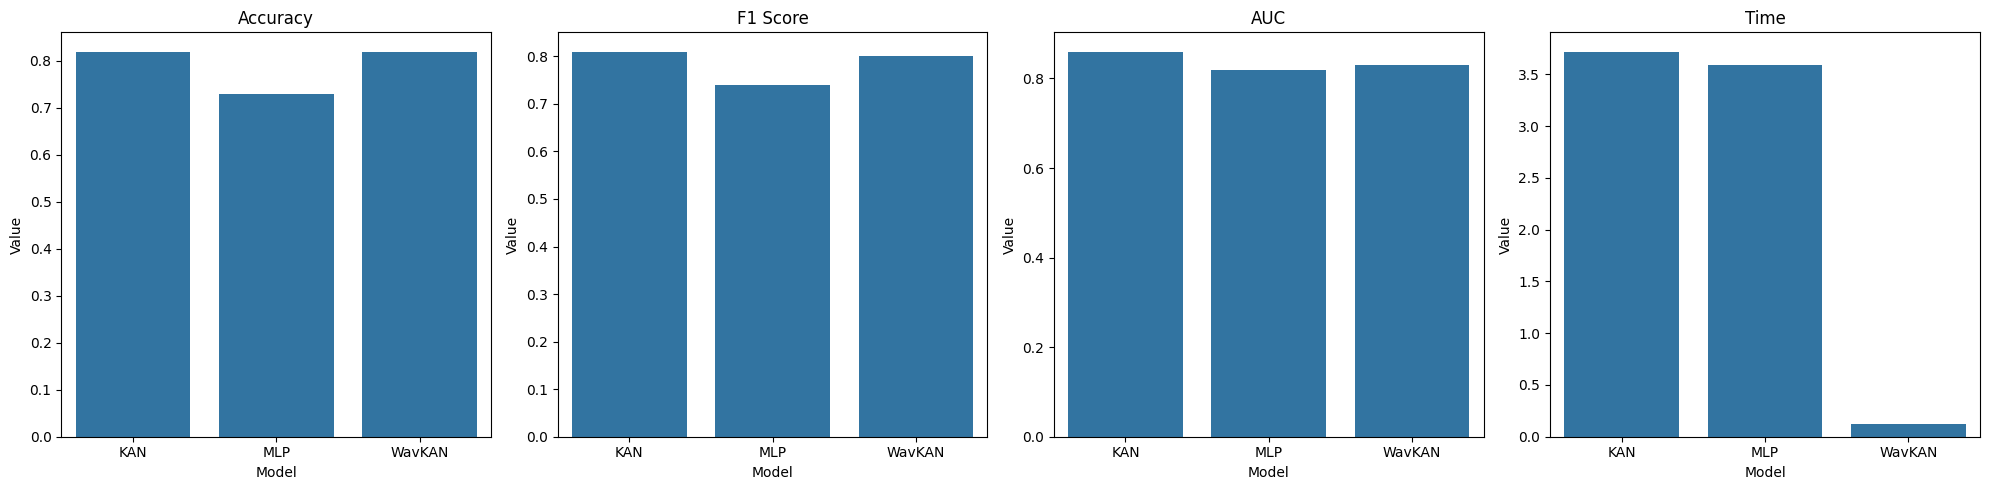

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data preparation
data = {
    'Model': ['MLP', 'KAN', 'WavKAN'] * 4,
    'Metric': ['Accuracy', 'Accuracy', 'Accuracy',
               'F1 Score', 'F1 Score', 'F1 Score',
               'AUC', 'AUC', 'AUC',
               'Time', 'Time', 'Time'],
    'Value': [0.73, 0.82, 0.82,
              0.74, 0.81, 0.80,
              0.82, 0.86, 0.83,
              3.59, 3.72, 0.12]
}

df = pd.DataFrame(data)

# Pivot the data for plotting
df_pivot = df.pivot(index='Model', columns='Metric', values='Value')

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=False)
sns.barplot(x=df_pivot.index, y=df_pivot['Accuracy'], ax=axes[0])
sns.barplot(x=df_pivot.index, y=df_pivot['F1 Score'], ax=axes[1])
sns.barplot(x=df_pivot.index, y=df_pivot['AUC'], ax=axes[2])
sns.barplot(x=df_pivot.index, y=df_pivot['Time'], ax=axes[3])

# Setting titles for each subplot
axes[0].set_title('Accuracy')
axes[1].set_title('F1 Score')
axes[2].set_title('AUC')
axes[3].set_title('Time')

# Setting labels
for ax in axes:
    ax.set_xlabel('Model')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Data preparation
data = {
    'Model': ['MLP', 'KAN', 'WavKAN'] * 4,
    'Metric': ['Accuracy', 'Accuracy', 'Accuracy',
               'F1 Score', 'F1 Score', 'F1 Score',
               'AUC', 'AUC', 'AUC',
               'Time', 'Time', 'Time'],
    'Value': [0.73, 0.82, 0.82,
              0.74, 0.81, 0.80,
              0.82, 0.86, 0.83,
              3.59, 3.72, 0.12]
}

df = pd.DataFrame(data)
print("Performance Metrics Table:")
print(df.pivot_table(index='Metric', columns='Model', values='Value'))


Performance Metrics Table:
Model      KAN   MLP  WavKAN
Metric                      
AUC       0.86  0.82    0.83
Accuracy  0.82  0.73    0.82
F1 Score  0.81  0.74    0.80
Time      3.72  3.59    0.12


<ipython-input-76-699a34bc765f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_pivot.index, y=df_pivot['Accuracy'], ax=axes[0], palette='viridis')


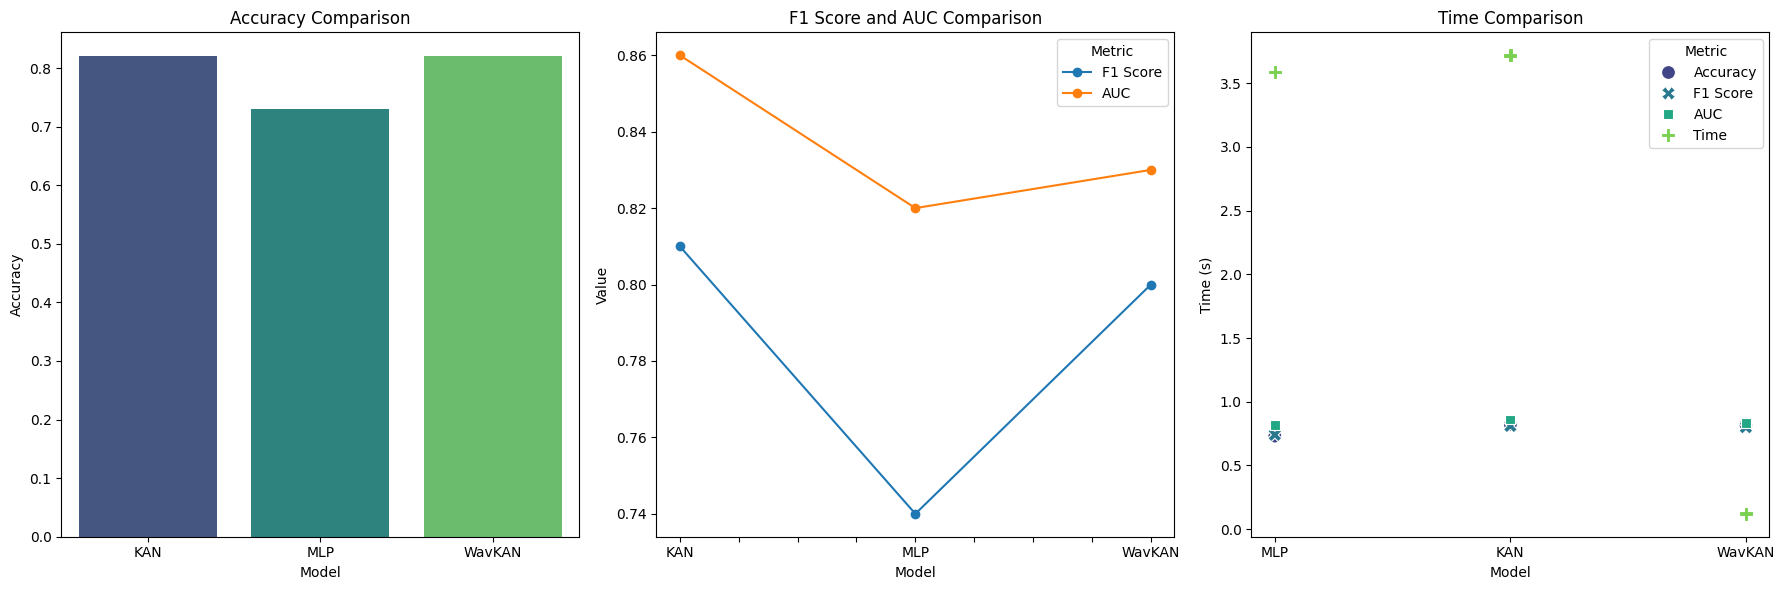

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot the data for plotting
df_pivot = df.pivot(index='Model', columns='Metric', values='Value')

# Plotting Bar, Line, and Scatter
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bar chart
sns.barplot(x=df_pivot.index, y=df_pivot['Accuracy'], ax=axes[0], palette='viridis')
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylabel('Accuracy')

# Line chart
df_pivot[['F1 Score', 'AUC']].plot(kind='line', marker='o', ax=axes[1])
axes[1].set_title('F1 Score and AUC Comparison')
axes[1].set_ylabel('Value')

# Scatter chart for Time
sns.scatterplot(data=df, x='Model', y='Value', hue='Metric', style='Metric', ax=axes[2],
                palette='viridis', s=100)
axes[2].set_title('Time Comparison')
axes[2].set_ylabel('Time (s)')

plt.tight_layout()
plt.show()


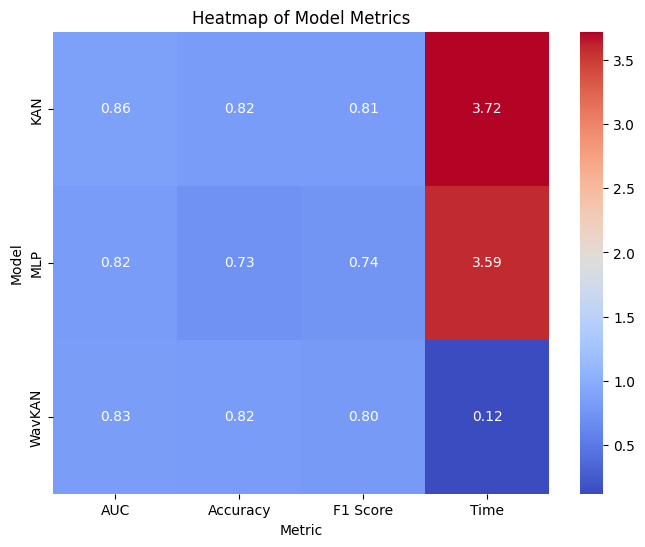

In [ ]:
# Heatmap of performance metrics
plt.figure(figsize=(8, 6))
sns.heatmap(df_pivot, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Model Metrics')
plt.show()


<ipython-input-88-2d41737a93ef>:45: RuntimeWarning: divide by zero encountered in log
  mlp_loss = -np.mean(y_train * np.log(mlp_probs[:, 1]) + (1 - y_train) * np.log(1 - mlp_probs[:, 1]))
<ipython-input-88-2d41737a93ef>:45: RuntimeWarning: divide by zero encountered in log
  mlp_loss = -np.mean(y_train * np.log(mlp_probs[:, 1]) + (1 - y_train) * np.log(1 - mlp_probs[:, 1]))
<ipython-input-88-2d41737a93ef>:45: RuntimeWarning: divide by zero encountered in log
  mlp_loss = -np.mean(y_train * np.log(mlp_probs[:, 1]) + (1 - y_train) * np.log(1 - mlp_probs[:, 1]))
<ipython-input-88-2d41737a93ef>:45: RuntimeWarning: divide by zero encountered in log
  mlp_loss = -np.mean(y_train * np.log(mlp_probs[:, 1]) + (1 - y_train) * np.log(1 - mlp_probs[:, 1]))
<ipython-input-88-2d41737a93ef>:45: RuntimeWarning: divide by zero encountered in log
  mlp_loss = -np.mean(y_train * np.log(mlp_probs[:, 1]) + (1 - y_train) * np.log(1 - mlp_probs[:, 1]))
<ipython-input-88-2d41737a93ef>:45: RuntimeWarning: div

MLP - Accuracy: 0.72, F1 Score: 0.71, AUC: 0.79, Time: 7.98s
KAN - Accuracy: 0.82, F1 Score: 0.81, AUC: 0.86, Time: 4.81s
WavKAN - Accuracy: 0.82, F1 Score: 0.80, AUC: 0.83, Time: 0.13s


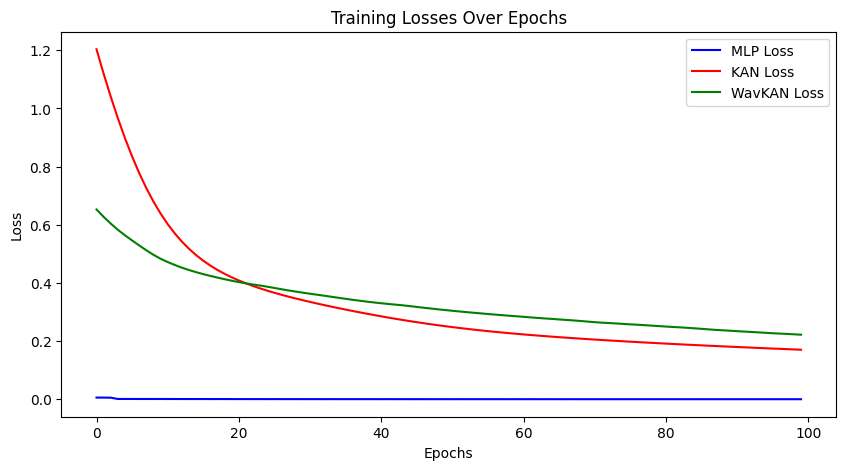

Performance Metrics Table:
Model          KAN       MLP    WavKAN
Metric                                
AUC       0.863839  0.793527  0.829241
Accuracy  0.816667  0.716667  0.816667
F1 Score  0.813559  0.711864  0.800000
Time      4.806821  7.984703  0.125026


<ipython-input-88-2d41737a93ef>:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_pivot.index, y=df_pivot['Accuracy'], ax=axes[0], palette='viridis')


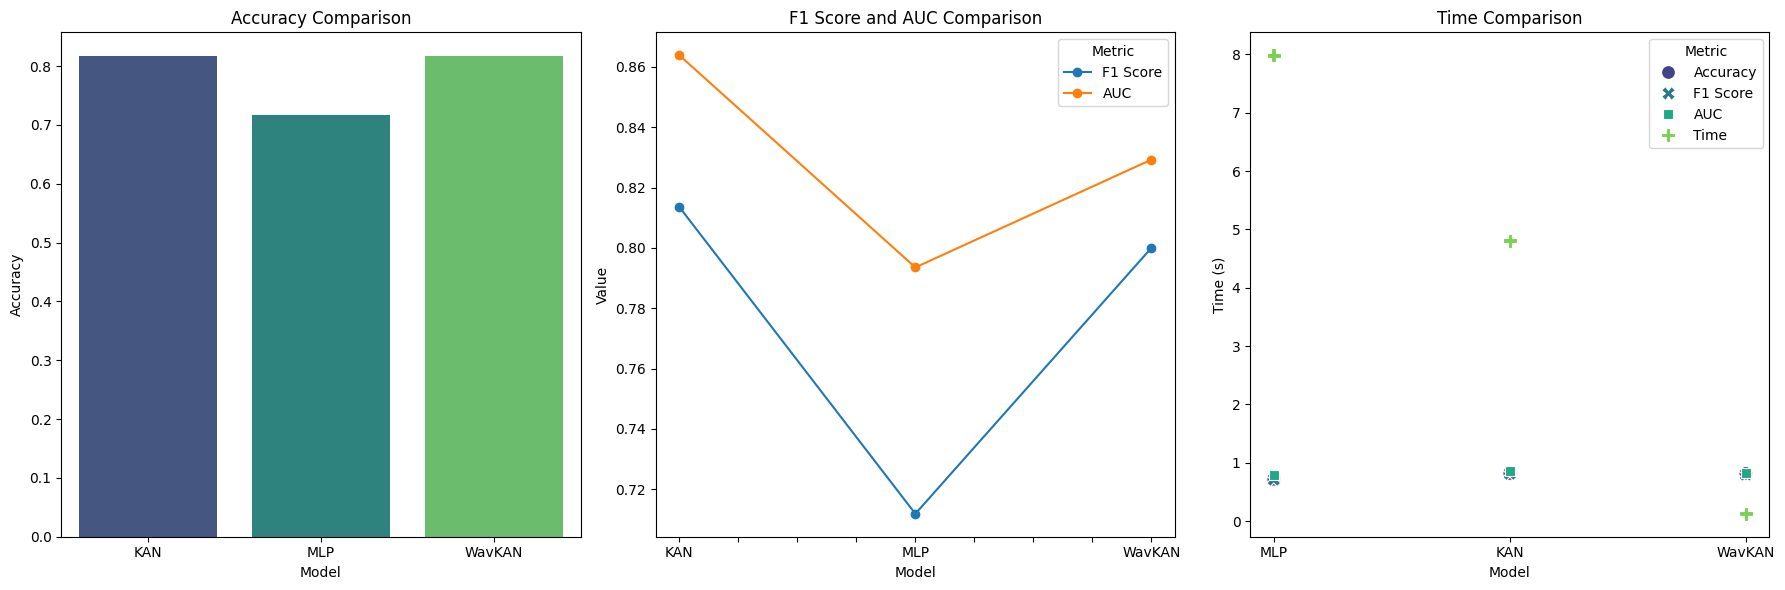

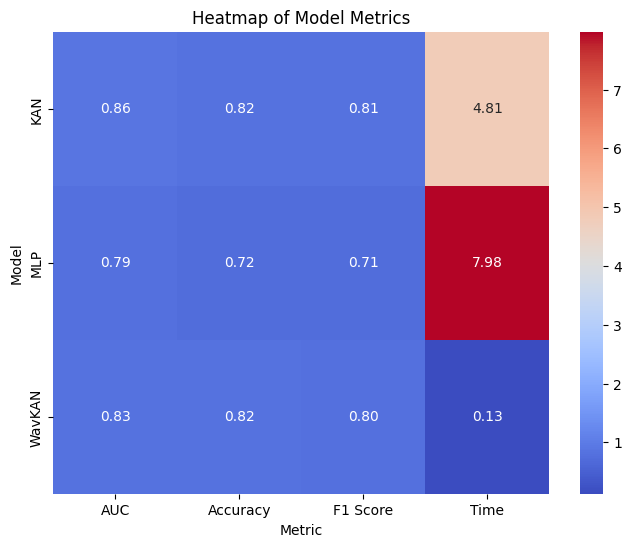

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'kan.py' is a module with KAN class properly defined
from kan import KAN  # Importing traditional KAN if needed

# Load dataset
df = pd.read_csv("/content/heart_cleveland_upload.csv")

# Preprocessing
X = df[df.columns[:-1]]
y = df['condition']
X = StandardScaler().fit_transform(X)  # Normalizing data

# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to Torch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.to_numpy(), dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Initialize MLP
mlp = MLPClassifier(random_state=42, max_iter=1000, warm_start=True, hidden_layer_sizes=(100, 100))
start_time = time.time()

mlp_losses = []
epochs = 100
for epoch in range(epochs):
    mlp.fit(X_train, y_train)
    # Predict on the training set to calculate loss
    mlp_probs = mlp.predict_proba(X_train)
    mlp_loss = -np.mean(y_train * np.log(mlp_probs[:, 1]) + (1 - y_train) * np.log(1 - mlp_probs[:, 1]))
    mlp_losses.append(mlp_loss)
mlp_duration = time.time() - start_time
mlp_preds = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, mlp_preds)
mlp_f1 = f1_score(y_test, mlp_preds)
mlp_auc = roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])

# Evaluate the MLP
mlp_preds = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, mlp_preds)
mlp_f1 = f1_score(y_test, mlp_preds)
mlp_auc = roc_auc_score(y_test, mlp.predict_proba(X_test)[:, 1])

# Define and initialize the KAN models
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, wavelet_type='dog'):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.wavelet_type = wavelet_type
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        x = torch.mm(x, self.weights.t()) + self.bias
        return F.relu(x)  # Assuming ReLU activation; adjust as necessary

class KANWavelet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, wavelet_type='dog'):
        super(KANWavelet, self).__init__()
        layers = [KANLinear(input_size, hidden_sizes[0], wavelet_type)]
        for i in range(1, len(hidden_sizes)):
            layers.append(KANLinear(hidden_sizes[i-1], hidden_sizes[i], wavelet_type))
        layers.append(KANLinear(hidden_sizes[-1], output_size, wavelet_type))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Initialize traditional KAN and Wavelet KAN
kan = KAN(width=[X_train.shape[1], 2], grid=15, k=15)
kan_model = KANWavelet(input_size=X_train.shape[1], hidden_sizes=[10], output_size=2, wavelet_type='dog')
optimizer_kan = optim.Adam(kan.parameters(), lr=0.01)
optimizer_wavkan = optim.Adam(kan_model.parameters(), lr=0.01)

# Define training and evaluation function with loss recording
def train_and_evaluate(model, optimizer, X_train, y_train, X_test, y_test, epochs=100):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = F.cross_entropy(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())  # Record loss for each epoch

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X_test), dim=1)
        acc = accuracy_score(y_test, preds.numpy())
        f1 = f1_score(y_test, preds.numpy())
        auc = roc_auc_score(y_test, F.softmax(model(X_test), dim=1)[:, 1].numpy())
    return acc, f1, auc, losses

# Train and evaluate traditional KAN and Wavelet KAN



kan_start_time = time.time()
kan_acc, kan_f1, kan_auc, kan_losses = train_and_evaluate(kan, optimizer_kan, X_train_torch, y_train_torch, X_test_torch, y_test_torch, epochs=100)
kan_duration = time.time() - kan_start_time

wkan_start_time = time.time()
wavkan_acc, wavkan_f1, wavkan_auc, wavkan_losses = train_and_evaluate(kan_model, optimizer_wavkan, X_train_torch, y_train_torch, X_test_torch, y_test_torch, epochs=100)
wkan_duration = time.time() - wkan_start_time

# Print results and plot losses
print(f"MLP - Accuracy: {mlp_acc:.2f}, F1 Score: {mlp_f1:.2f}, AUC: {mlp_auc:.2f}, Time: {mlp_duration:.2f}s")
print(f"KAN - Accuracy: {kan_acc:.2f}, F1 Score: {kan_f1:.2f}, AUC: {kan_auc:.2f}, Time: {kan_duration:.2f}s")
print(f"WavKAN - Accuracy: {wavkan_acc:.2f}, F1 Score: {wavkan_f1:.2f}, AUC: {wavkan_auc:.2f}, Time: {wkan_duration:.2f}s")

plt.figure(figsize=(10, 5))
plt.plot(mlp_losses, label='MLP Loss', color='blue')
plt.plot(kan_losses, label='KAN Loss', color='red')
plt.plot(wavkan_losses, label='WavKAN Loss', color='green')
plt.title('Training Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Data preparation
data = {
    'Model': ['MLP', 'KAN', 'WavKAN'] * 4,
    'Metric': ['Accuracy', 'Accuracy', 'Accuracy',
               'F1 Score', 'F1 Score', 'F1 Score',
               'AUC', 'AUC', 'AUC',
               'Time', 'Time', 'Time'],
    'Value': [mlp_acc, kan_acc, wavkan_acc,
              mlp_f1, kan_f1, wavkan_f1,
              mlp_auc, kan_auc, wavkan_auc,
              mlp_duration, kan_duration, wkan_duration]
}

df = pd.DataFrame(data)
print("Performance Metrics Table:")
print(df.pivot_table(index='Metric', columns='Model', values='Value'))

# Pivot the data for plotting
df_pivot = df.pivot(index='Model', columns='Metric', values='Value')

# Plotting Bar, Line, and Scatter
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bar chart
sns.barplot(x=df_pivot.index, y=df_pivot['Accuracy'], ax=axes[0], palette='viridis')
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylabel('Accuracy')

# Line chart
df_pivot[['F1 Score', 'AUC']].plot(kind='line', marker='o', ax=axes[1])
axes[1].set_title('F1 Score and AUC Comparison')
axes[1].set_ylabel('Value')

# Scatter chart for Time
sns.scatterplot(data=df, x='Model', y='Value', hue='Metric', style='Metric', ax=axes[2],
                palette='viridis', s=100)
axes[2].set_title('Time Comparison')
axes[2].set_ylabel('Time (s)')

plt.tight_layout()
plt.show()

# Heatmap of performance metrics
plt.figure(figsize=(8, 6))
sns.heatmap(df_pivot, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Model Metrics')
plt.show()

